# Introduction à knn
---
Le but de ce TP est de mieux appréhender l'apprentissage via une méthode type 'plus proches voisins'. 
--- 

## Conseils
- Pour chaque question, essayer d'écrire des fonctions plutôt que des scripts
- Eviter d'avoir deux fonctions qui portent le même nom (redéfinition de la fonction), préférer ajouter un paramètre de choix

---
# Construction d'un jeu de données simple
---
Dans ce TP, on n'utili pas un jeu de données existant, mais on en fabrique un, d'un niveau de complexité adéquat, et dont on connait en réalité parfaitement la loi.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from scipy.stats import norm
from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix

## Ecrire une fonction ```separation```
- Entrée :  un couple (x, y) de flottants
- Sortie : 'A' si y<f(x)  et 'B' sinon, où $f(x) = \frac{x}{3}*\left(2+\cos\left(\frac{x}{6}\right)\right)$

In [2]:
def f(x):
    return (x/3) * (2+np.cos(x/6))

In [3]:
def separation(x,y):
    
    if (y < f(x)):
        return 'A'
    else:
        return 'B'

## Ecrire une fonction ```donneesSimples``` 
- Entrée : 
    - ```N``` un entier 
    - ```f``` une fonction prenant en entrée deux flottants
- Sortie : un dataframe de ```N``` échantillons de 3 attributs :
  - ```abscisse``` : tiré en aléatoire uniforme dans [0 ; 100], flottant
  - ```ordonnee``` : tiré en aléatoire uniforme dans [0 ; 100], flottant
  - ```classe = f(abscisse, ordonnée)```
- vous *devez* utiliser un apply de la fonction ```séparation```

In [4]:
def donneesSimples(N, func):
    df = pd.DataFrame(dict(
        abscisse=np.random.randint(0,100, size=N).astype("float"), 
        ordonnee=np.random.randint(0,100, size=N).astype("float")))
    df["classe"] = df.apply(lambda row: func(row['abscisse'],row['ordonnee']), axis=1)
    return df

  
## Ecrire une fonction ```representation```
Cette fonction génère une représentation graphique des données dans le plan

In [5]:
def representation(df):
    sns.scatterplot(x='abscisse', y='ordonnee', data=df, hue='classe')
    sns.lineplot(x = np.linspace(0, 100, 100), y = f(np.linspace(0, 100, 100)))
    


## Créer une BD ```donnees``` de 600 données
- par application de ```donneesSimples(600 separation)```

In [6]:
df = donneesSimples(600, separation)

## Représenter la base de donnée graphiquement
Un scatterplot pour les points et un lineplot pour la séparation théorique donnent un graphique pertinent.

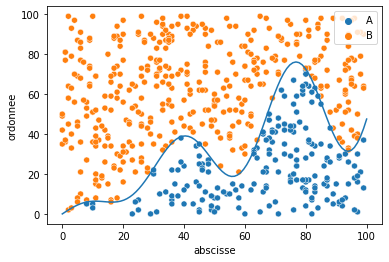

In [7]:
representation(df)

## En utilisant scikit-learn, séparer ```donnees``` en deux ensembles
Ecrire la fonction , fonction ```creerBases``` qui sépare la base de données en :
- apprentissage (et validation) : 50%
- validation et test 50%  
 
**NB** : dans ce TP, l'ensemble de test servira d'ensemble de validation.

**NB2** : à la fin de cette étape, on doit disposer de deux dataframes, un pour l'apprentissage, un pour validation/test

In [8]:
def creerBases(df):
    Y = df.classe
    col = ['abscisse', 'ordonnee']
    X = df[col]
    return train_test_split(X, Y, train_size=0.5, test_size=0.5, stratify=Y, random_state=1)

train_X, test_X, train_Y, test_Y = creerBases(df)

# Théorie et sa mise en pratique dans sklearn
- Rappeler le fonctionnement de la classification par knn
- Expliquer les variations proposées par 'algorithm'
- Expliquer l'influence de 'p' dans la distance de Minkowski (exemples à l'appui)
- Expliquer l'influence de 'weight' (exemples à l'appui)

# Représenter la surface de séparation en fonction du nombre de voisins
## Fonction de coloration
Ecrire une fonction ```colorationPlan``` qui produit une représentation [0 ; 100]x[0 ; 100] colorée en fonction de la classe attribuée par votre classifieur.
en fonction de la classe attribuée par votre classifieur à chacun de ses points.
- Entrées : 
    - ```classifieur``` une fonction de classification (pour vérifier votre code, prenez un classifieur de votre choix dans sklearn)
    - ```NbPts``` nombre de points à prendre dans chaque direction pour discrétiser [0 ; 100]x[0 ; 100]

In [9]:
def genererPoints(nbPts):
    return pd.DataFrame([(x,y) for x in np.linspace(0, 100, nbPts) for y in np.linspace(0, 100, nbPts)], 
                        columns = ['abscisse', 'ordonnee'])
    
def colorationPlan(classifieur, nbPts):
    df = genererPoints(nbPts) 
    df['classe'] = classifieur.predict(df)
    representation(df)

## Observer et analyser l'influence du choix de 'k' sur la classification obtenue
Pour différentes valeurs de ```k``` dans le classifieur, utiliser la fonction ```colorationPlan``` et comparer les résultats.

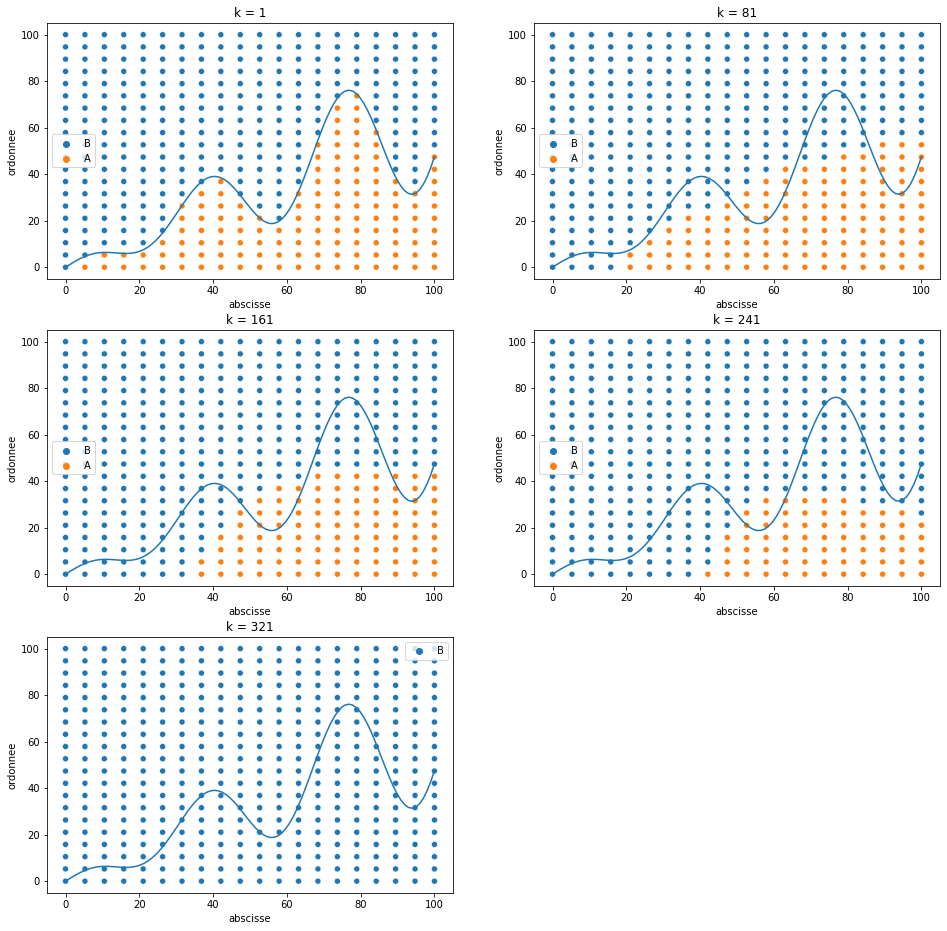

In [10]:
def plotKnn(k, nbPts, df):
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(df.iloc[:, :2], df['classe'])
    colorationPlan(knn, nbPts)
    
def plotsKnn(f):
    df = genererPoints(20)
    df['classe'] = df.apply(lambda row: f(row['abscisse'], row['ordonnee']), axis=1)
    plt.figure(figsize=[16, 16])
    i=1
    for k in range(1, 20*20, 80):
        ax = plt.subplot(320+i)
        ax.title.set_text('k = '+str(k))
        plotKnn(k, 20, df)
        i+=1

plotsKnn(separation)

## Commenter
- Essayer d'expliquer les résultats obtenus
- Entre deux résultats équivalents pour deux valeurs de 'k' différentes, lequel choisir ?

## Recherche des paramètres optimaux
- utiliser une gridsearch pour déterminer les meilleurs paramètres, expliquer la valeur de cv

In [11]:
def bestKnn(df, cv):
    param_grid=dict(n_neighbors=list(range(1, 21)))
    knn = KNeighborsClassifier()
    grid = GridSearchCV(knn, param_grid, cv=cv, scoring='accuracy')
    grid.fit(df.drop('classe', axis=1), df['classe'])
    
    return grid.best_params_['n_neighbors']

# Représenter la matrice de confusion sur l'ensemble de validation

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Text(0.5, 1.0, 'Matrice de confusion')

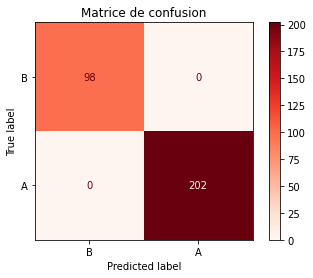

In [12]:
#Création du classifieur
knn = KNeighborsClassifier(n_neighbors = bestKnn(df, 6))
knn.fit(train_X, train_Y)

predic = knn.predict(train_X)
mc = metrics.confusion_matrix(train_Y,predic)

display_mc = metrics.plot_confusion_matrix(knn, train_X, train_Y, display_labels = train_Y.unique(), cmap = plt.cm.Reds,
normalize = None)
display_mc.ax_.set_title("Matrice de confusion")

# Créer deux nouvelles bases d'apprentissage une de 100 données, une de 1000 données
- Observer l'influence de la quantité de données sur les valeurs optimales du paramètre 'k', expliquer
- Observer l'influence de la quantité de données sur la qualité du résultat obtenu, expliquer (faire attention à mesurer la qualité de l'apprentissage sur l'ensemble validation/test !)
- Observer l'influence de la quantité de données sur le temps de calcul, expliquer

*NB* : afin d'obtenir des résultats pertinents, il est nécessaire de relancer ce travil un certain nombre de fois afin d'en dégager une tendance statistique.

In [13]:
new_df_1 = donneesSimples(100, separation)
new_df_2 = donneesSimples(1000, separation)

def tester(data, cv):
    train_X, test_X, train_Y, test_Y = creerBases(data)

    knn = KNeighborsClassifier(n_neighbors = bestKnn(data, cv))
    knn.fit(train_X, train_Y)
    
    plt.figure(figsize=[20, 7])
    ax1 = plt.subplot(121)
    df = train_X
    df['classe'] = knn.predict(train_X)
    acc = accuracy_score(df['classe'], train_X.apply(lambda row: separation(row[0], row[1]), axis=1))
    ax1.title.set_text('Ensemble de validation(precision = '+str(acc)+')')
    representation(df)
    ax2 = plt.subplot(122)
    df = test_X
    df['classe'] = knn.predict(test_X)
    acc = accuracy_score(df['classe'], test_X.apply(lambda row: separation(row[0], row[1]), axis=1))
    ax2.title.set_text('Ensemble de test(precision = '+str(acc)+')')
    representation(df)

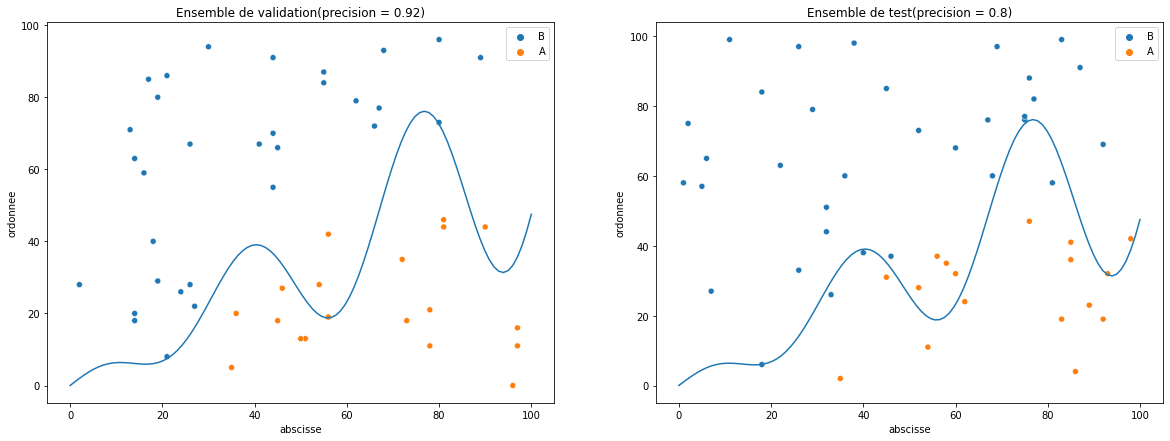

In [14]:
tester(new_df_1, 6)

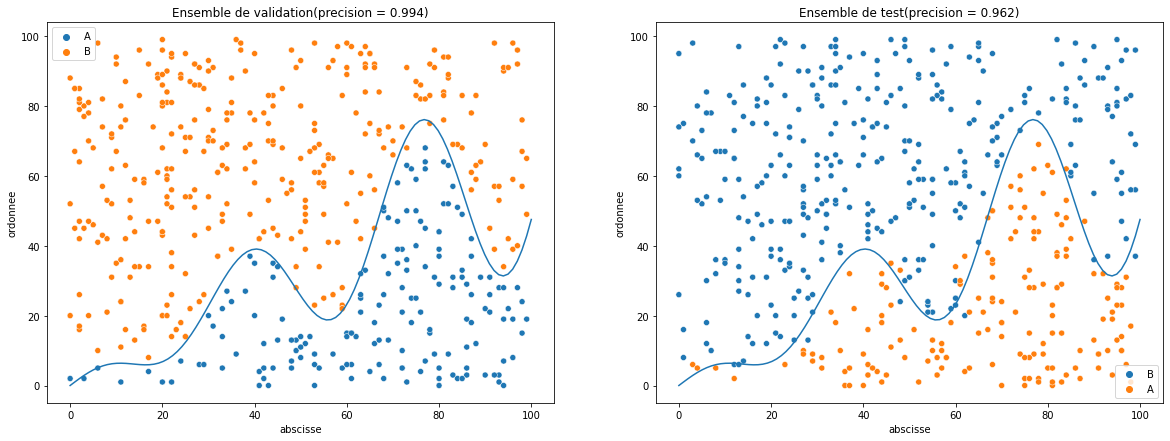

In [15]:
tester(new_df_2, 6)

---
# Effet du bruit
Dans cette partie on va examiner la résistance au bruit de l'algorithme, et son influence sur le choix du nombre de voisins.
---
Cette étude a pour vocation de mieux comprendre le choix des paramètres lorsque certaines données sont incorrectes, ou lorsque le modèle contient des irrégularité non aisément modélisables (par exemple si la classe n'est pas totalement une fonction des entrées).

## Génération des données
Ecrire une fonction prenant en entrée un DataFrame 'T' servant à l'apprentissage et une probabilité $0\leq p\leq 1$ qui renvoie un nouveau dataframe qui est une copie de 'T', mais où la classe des exemples a été altérée avec la probabilité $p$ : pour chaque ligne du dataframe, la classe est inchangée avec la probabilité $1-p$, et modifiée avec la probabilité $p$.


## Analyser l'effet de la force du bruit sur les meilleurs paramètres du modèle
Représenter le nombre optimal de voisins à choisir en fonction de la valeur du paramètre $p$.

## Conclure, et vérifier l'effet sur les autres paramètres

---
# Influence des corrélations entre les attributs
---
On travaille à nouveau sur une base de données non bruitée. Ecrire une fonction prenant en entrée un DataFrame de même natyure que train ou test, et qui en renvoie une copie à laquelle on a ajouté 5 colonnes définies par :
- U1 :   $+300 \times X + 0.1 \times Y$
- U2 :   $-4000 \times X - 0.01 \times Y$
- U3 :   $-700 \times X + 0.12 \times Y$
- U4 :   $-280 \times X + 1.5 \times Y$
- U3 :   $+5100 \times X - 1.2 \times Y$  

NB : Remettre la colonne ```classe``` en dernière colonne.

In [16]:
def donneesCorrelees(N, f):
    X = np.random.randint(0,100, size=N).astype("float")
    Y = np.random.randint(0,100, size=N).astype("float")
    U1 = 300*X+0.1*Y
    U2 = -4000*X-0.01*Y
    U3 = -700*X+0.12*Y
    U4 = -280*X+1.5*Y
    U5 = 5100*X-1.2*Y
    df = pd.DataFrame({'abscisse':X, 'ordonnee':Y, 'U1': U1, 'U2':U2, 'U3':U3, 'U4':U4, 'U5':U5})
    df['classe'] = df.apply(lambda row: f(row['abscisse'], row['ordonnee']), axis=1)
    return df

new_df = donneesCorrelees(600, separation)

# Observer la diférence de qualité entre :
- Apprendre en utilisant toutes les observations (x, y, u1, u2, u3, u4, u5)
- Apprendre en n'utilisant que les observations (x,y)

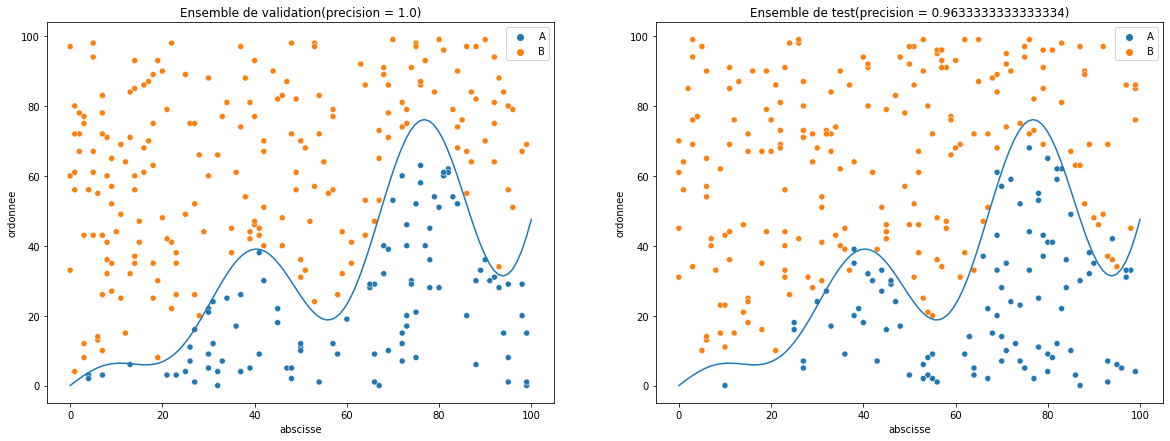

In [17]:
tester(new_df, 6)

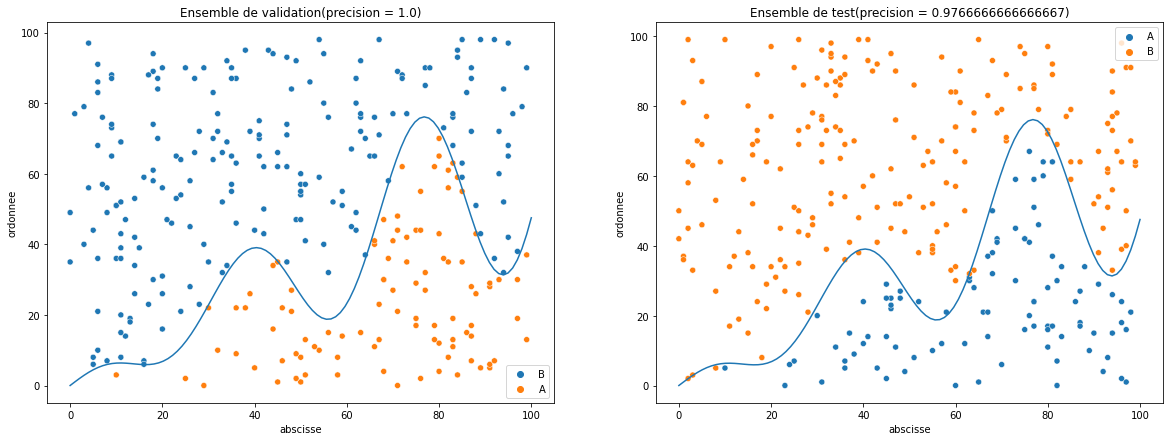

In [18]:
tester(df, 6)


## Expliquer la raison de la différence observée

## Utiliser un preprocessing adapté sur les données afin que la qualité obtenue en apprenant sur le jeu de données (x, y, u1, u2, u3, u4, u5) soit comparable à celle obtenue en n'utilisant que (x, y)

expliquer et pointer les limitations, proposer des améliorations


---
# Merci d'avoir suivi ce TP, j'espère qu'il vous a aidé à mieux appréhender l'utilisation de knn, et vous a permis de faire quelques pas dans le domaine *passionnant* de l'apprentissage artificiel